# Comparison of Results from the Principal-Agent Model with  and without Education as signaling

Imports and set magics:

In [72]:
import numpy as np
from scipy import optimize
import sympy as sm
from types import SimpleNamespace
from IPython.display import display
from scipy.stats import norm

import pandas as pd 
import matplotlib.pyplot as plt
import ipywidgets as widgets

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# local modules
from modelproject import PrincipalAgent

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# The Principal Agent Model


### Part 1: The Principal Agent Model with adverse selection

Consider an economy that consists of a principal that wish to hire workers. There are two types of workers, respectively high and low productivity workers, and the principal is not able to distinguish the two types from each other. The principal therefore faces the following maximization problem:

$$
\begin{align*}
\max_{w} \pi  & = q(y_H - w)+(1-q)(y_L - w)\\
& \text{s.t.} \\
\tag{$IR_H$} w & \ge r_H \\ 
\tag{$IR_L$} w & \ge r_L
\end{align*}
$$

where $w$ is the wage rate, $r_i$ is the outside utility and $y_i$ is the productivity. The subscript $i$ of either H or L denotes if the agent has high ($H$) or low productivity ($L$). Furthermore, we assume that the agents recieve utility corresponding to their wage.

THe constraints under which we optimize the profits are called the individual rationality constraints ($IR_H$/$IR_L$). They ensure that the agents accept the offered contract. This implies that the utility of accepting the contract is higher than their outside utility.

The baseline parameters are stated below:

In [73]:
model = PrincipalAgent()
for name,value in model.par.__dict__.items():
    print(f'par.{name} = {value}')

par.alpha = 3.0
par.q = 0.5
par.b_L = 2.5
par.b_H = 1
par.y_L = 100
par.y_H = 200
par.r_H = 70
par.r_L = 30
par.e_max = 30
par.N = 100


Now, we solve the model with baseline parameter values: 
**Procedure**
1. First, we solve the model.
2. Next, we print the solution. 

In [74]:
model = PrincipalAgent()
model.solve_one()
print(f'w={model.sol.w:.2f}')
print(f'profits={model.profits_one(model.sol.w):.3f}')

w=70.00
profits=80.000


We see that when the principal can only offer one contract to both types of workers, the equilibirum wage will be 70 which implies  total profits of 80. Since the profits are positive, and the wage offered is higher than both of the agents' outside option the principal will wish to employ this solution. In fact the wage offered only needs to be higher than the highest outside option, so *so only the $IR_H$ will bind* in equilibrium.

#### Increasing the outside option

Above, we argued that only the $IR_H$ will bind in equilibrium. Now, we examine what an increase in this outside option will imply for the solution to the model (the conntract offered). We thus increase $r_H$ threefold, so $r_H=210$:

**Procedure**
1. First, we change the outside option for the high productive workers. 
2. Next, we solve the model. 
3. Finally, we print the solution. 

In [75]:
model.par.r_H = 210
model.solve_one()
print(f'w={model.sol.w:.2f}')
print(f'profits={model.profits_one(model.sol.w):.3f}')

w=30.00
profits=35.000


Now, we find that the offered wage in equilibrium falls, so $w=30$ thus implying profits of $\pi=70$.

The reason for the decrease in the wage is that the outside option of 210 is higher than the productivity of 200 of the high productivity workers. Therefore, the cost of hiring high productivity workers is higher than their contribution to the firm profits, and the principal chooses *not to hire the high productivity workers*. 

This is done exactly by offering a wage set so it is higher than the outside option of the low productivity workers, but low enough that the high productivity workers will not accept the offered contract. 

Now, we increase the outside option of low productivity workers, so this also exceeds their productivity. We set $r_L=110$:

**Procedure**
1. First, we change the outside option for the low productivity workers and high productive workers. 
2. Next, we solve the model. 
3. Finally, we print the solution. 

In [76]:
model.par.r_L = 110
model.par.r_H = 210
model.solve_one()
print(f'w={model.sol.w:.2f}')
print(f'profits={model.profits_one(model.sol.w):.3f}')

w=0.00
profits=0.000


We find that under these assumptions where the outside option exceeds the productivity for both workers, the principal chooses not to offer any contract to the workers. This implies no production and thus $\pi=0$.

The intuition behind the result is, that when the outside option is larger than the agents productivity, the wage that ensures that the agents accept the contract needs to be so high that the profit for the principal is negative. Therefore the principal will not employ any of the agents and the profit will be 0. 

### Part 2: Introducing Education as Signaling

We again consider an economy that consists of a principal that wish to hire workers. There are two types of workers, resepctively high and low productivity workers, and the principal is not able to distinguish the two types from each other. Moreover, the principal observes the education level of the worker and is able to condition on the education level in the contracts. Hence, the principal's objective is to design two contracts, each consisting on a wage and a required education level, that maximizes the total profit of the firm. 

This can be collapsed to the following maximization problem: 
$$
\begin{align*}
\max_{w_H,e_H,w_L,e_L} \pi  & = q(R_H - w_h)+(1-q)(R_L - w_L)\\
& \text{s.t.} \\
\tag{$IR_H$}u_H(w_h,e_H) & \ge r_H \\ 
\tag{$IR_L$}u_L(w_L,e_L) & \ge r_L \\ 
\tag{$IC_H$}u_H(w_H,e_H) & \ge u_H(w_L,e_L)\\
\tag{$IC_L$}u_L(w_L,e_L) & \ge u_L(w_H,e_H)
\end{align*}
$$
where $w_i$ is the wage rate, $e_i$ is the level of education, $r_i$ is the outside utility, $u_i$ is the utility function and $R_i$ is the revenue added by worker i to the total firm revenue. The subscript $i$ of either L or H denotes if the agent has high ($H$) or low productivity ($L$).


The individual rationality constraints ($IR_H$/$IR_L$) ensures that the agents accept the offered contract. This implies that the utility of accepting the contract is higher than the outside utility. The incentive compatible constraints ($IC_H$/$IC_L$) ensures that the workers only accept the contract that is meant for them, i.e low productivity workers don't accept the contract meant for high productivity workers (and in principle also vise versa). 

We have assumed the functional forms of the various functions given below:

$$
\begin{align*}
u_H & = w - b_H * f(e_H)\\
u_L & = w - b_L * f(e_L) \\
R_H & = y_H + \alpha * e_H \\
R_L & = y_L + \alpha * e_L \\
\end{align*}
$$

where $f'(e_i)>0$ and $f''(e_i)>0$, the variables are defined as above and $b_i$ is a scalar that denotes the size of the utility cost the agent i faces when taking an education. $\alpha$ is the effect of education on the firm revenue.

The baseline parameters are stated below:

In [77]:
model = PrincipalAgent()
for name,value in model.par.__dict__.items():
    print(f'par.{name} = {value}')

par.alpha = 3.0
par.q = 0.5
par.b_L = 2.5
par.b_H = 1
par.y_L = 100
par.y_H = 200
par.r_H = 70
par.r_L = 30
par.e_max = 30
par.N = 100



**Procedure**
1. First, we now solve the model given above with the parameter values stated above 
3. Next, we print the solution.

In [78]:
model.solve()
print(f'(w_L,e_L,w_H,e_H)=({model.sol.w_L:.3f},{model.sol.e_L:.3f},{model.sol.w_H:.3f}, {model.sol.e_H:.3f})')
print(f'profits={model.profits(model.sol.w_L,model.sol.e_L,model.sol.w_H,model.sol.e_H):.3f}')

(w_L,e_L,w_H,e_H)=(42.041,8.826,96.671, 19.214)
profits=122.703


When the principal can use the education level as a signal for the abilities of the workers and also offer the two agents seperate contracts, we have a solution that implies two different demanded education levels thus resulting in two different wages. 

In equilibrium not all constraints will bind. 

We can illustrate which of the constraints that bind by examining a plot of solutions, the indifference curves of the two agents and the incurred isoprofit curves (that is, all the combinations of wage and demanded education levels that yield the same profits). 

This is done below
IR_H IR_L IC_L

**Procedure**
1. First, we solve the model. 
2. Next, we find the indifferent curves and the isoprofit curves. 
3. Finally, we plot everything.

(w_L,e_L,w_H,e_H)=(42.041,8.826,96.671, 19.214)
profits=122.703


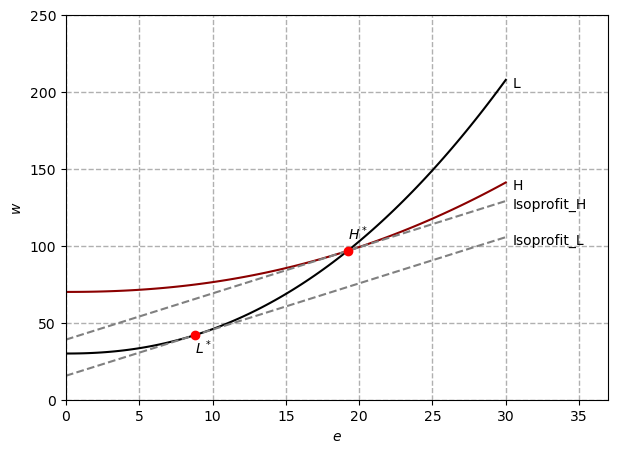

In [79]:
model.solve() #solving the expanded model
print(f'(w_L,e_L,w_H,e_H)=({model.sol.w_L:.3f},{model.sol.e_L:.3f},{model.sol.w_H:.3f}, {model.sol.e_H:.3f})')
print(f'profits={model.profits(model.sol.w_L,model.sol.e_L,model.sol.w_H,model.sol.e_H):.3f}')
model.find_indifference_curves() # calling the function in the "PrincipalAgent"-class that finds the indifference curves
model.find_isoprofit_curves() # doing the same for isoprofit curves
model.plot_everything() # calling the plotting function

From the graph above, we can see that the isoprofit curve and utility curve for the low productivity workers are tangent to each other in the implied solution ($L^\ast$). The same goes for the isoprofit curve and utility curve for the high productivity workers in $H^\ast$. This means that both the $IR_L$ and $IR_H$ bind. 

Furthermore, we can assert that the $IC_L$ binds because the two utility curves cross each other in the solution $H^\ast$. THis means that the low productivity workers attain the same utility from choosing their designated contract and choosing the high productivity contract - which is exactly what the $IC_L$ postulates.

Now, we test the implications of increasing the cost of taking an education for the high productive workers, $b_H$.

**Procedure**
1. First, we change the cost of education for the high productive workers. 
2. We solve the model. 
2. We find the indifferent curves and the isoprofit curves. 
3. Finally, we plot everything.

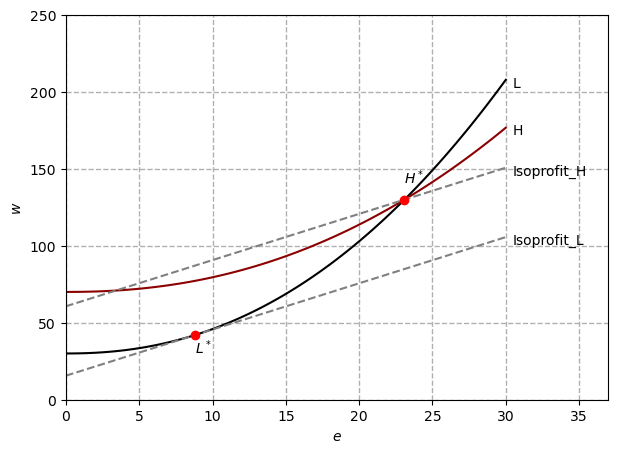

In [80]:
model.par.b_H=1.5 #increasing b_H
model.solve()
model.find_indifference_curves()
model.find_isoprofit_curves()
model.plot_everything()

Above, $IR_{H}$ does not bind anymore ($H^\ast$ is no longer in a point where $\text{Isoprofit}_H$ and the utility curve $H$ are tangent to each other). The intuition is that we increase the disutility cost of taking a longer education for high-productive workers, which means that in order to satisfy $IR_{H}$ the firm must increase the wage to high-productive workers at any given level of education. At the same level of education as the previous optimal contract for high-productive worker this wage increase will imply that low-productive workers have incentives to choose the contract intended for high-productive workers. To avoid this the firm increases both the wage and the required education level until the low-productive workers are indifferent between their own contract and the contract intented for the high-productive workers. That is when $IC_{L}$ binds. 

Now we see that an *information cost* has occured due to asymmetric information, because **under full information the firm could have designed a contract increasing its profits without making high-productive workers worse off**. Therefore, the outcome is no longer efficient.



### Part 3: Boundary/corner solutions

So far, the inner solutions for the extended model has maximized profits. However, with adequate parameter values (i.e., when the ratio between productivity level and outside option for a worker type is too low) the inner solution might not be the solution that maximizes the firm's profits. It may be the case that it is more profitable for the firm to design a single contract that only one of the worker types is willing to accept or a contract that none of them are willing to accept. Our algorithm accomodate these boundary and corner solutions as it compares the profits from the inner solution with the profits from potential boundary/corner solutions.

For example, below we have increased the outside option of the high productity workers a lot, such that the inner solution for high productivity workers will in all likelihood contribute negatively to the total profits of the firm. Therefore, in this case the actual solution is therefore a boundary solution. In this case, the profit maximizing behavior will therefore be to only design an optimal contract for the low productives, and hence not hire any high productivity workers.


In [81]:
model = PrincipalAgent()
model.par.r_H = 500
model.solve() 
print(f'(w_L,e_L,w_H,e_H)=({model.sol.w_L:.3f},{model.sol.e_L:.3f},{model.sol.w_H:.3f}, {model.sol.e_H:.3f})')
print(f'profits={model.profits(model.sol.w_L,model.sol.e_L,model.sol.w_H,model.sol.e_H):.3f}')

(w_L,e_L,w_H,e_H)=(42.035,8.823,0.000, 0.000)
profits=42.218


In the next example below, we now reset the parameter values and instead we increase the outside option of low productivity workers. In this case, the optimal contract becomes a boundary solution again. Now, it is optimal for the firm to design a contract that only high productivity workers are willing to accept. 

In [82]:
model = PrincipalAgent()
model.par.r_L = 200
model.solve() 
print(f'(w_L,e_L,w_H,e_H)=({model.sol.w_L:.3f},{model.sol.e_L:.3f},{model.sol.w_H:.3f}, {model.sol.e_H:.3f})')
print(f'profits={model.profits(model.sol.w_L,model.sol.e_L,model.sol.w_H,model.sol.e_H):.3f}')

(w_L,e_L,w_H,e_H)=(0.000,0.000,95.820, 18.933)
profits=80.489


Now, we consider an example where the differences between high producitivity and low productivity workers are very small regarding their respective outside options and idiosyncratic productivity levels. In that case, it might yield higher profits for the principal to design a single contract that both low productivity and high producitivity workers are willing to accept, because the differences between these workers are so small that the information costs in the inner solution becomes too high. An example of this can be seen below where both the outside option and productivity level for L is only 0.1% lower than the values for H. Thus, it is optimal to design a single contract that both high-and low productivity workers are willing to accept.

In [83]:
model = PrincipalAgent()
model.par.r_L = model.par.r_H*0.999
model.par.y_L = model.par.y_H*0.999
model.solve() 
print(f'(w_L,e_L,w_H,e_H)=({model.sol.w_L:.3f},{model.sol.e_L:.3f},{model.sol.w_H:.3f}, {model.sol.e_H:.3f})')
print(f'profits={model.profits(model.sol.w_L,model.sol.e_L,model.sol.w_H,model.sol.e_H):.3f}')

(w_L,e_L,w_H,e_H)=(81.965,8.824,81.965, 8.824)
profits=144.406


Finally, we consider an example below where both high producitiy and low productivity workers have a relatively high outside option compared to their idiosyncratic producitiy levels. In this case, we see that both the inner solutions and the two boundary solutions considered before implies negative total profits. Thus, it will now be profit maximizing the firm not to offer contracts to any of the worker types, and thereby obtain no profits.

In [84]:
model = PrincipalAgent()
model.par.r_L = 500
model.par.r_H = 200
model.solve() 
print(f'(w_L,e_L,w_H,e_H)=({model.sol.w_L:.3f},{model.sol.e_L:.3f},{model.sol.w_H:.3f}, {model.sol.e_H:.3f})')
print(f'profits={model.profits(model.sol.w_L,model.sol.e_L,model.sol.w_H,model.sol.e_H):.3f}')

(w_L,e_L,w_H,e_H)=(0.000,0.000,0.000, 0.000)
profits=0.000


### Part 4: Varying the shares of high- and low productivity workers

Now we'll visualize what different values of q will imply for the model. That is, what different shares of high and low productive workers imply for the wage and education level in optimum.

**Below, we illustrate the situation where there exists only low productivity workers in the economy:**

**Procedure**
1. First, we change the share of high productive workers.  
2. We solve the model. 
2. We find the indifferent curves and the isoprofit curves. 
3. Finally, we plot everything.

(w_L,e_L,w_H,e_H)=(42.033,8.823,0.000, 0.000)
profits=84.436


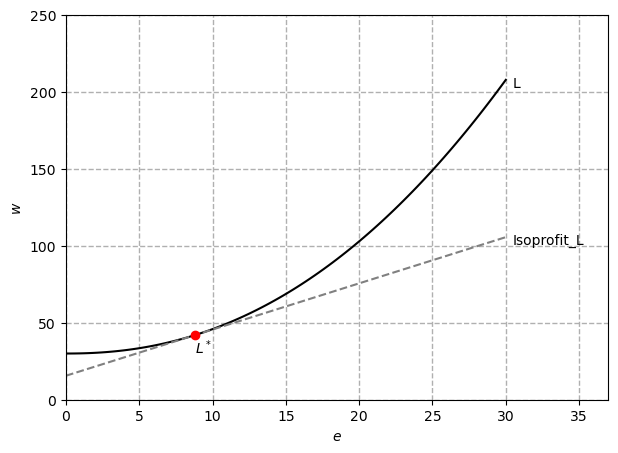

In [85]:
# Implementing only low productivity workers (q=0)
model = PrincipalAgent()
model.par.q=0

model.solve()
print(f'(w_L,e_L,w_H,e_H)=({model.sol.w_L:.3f},{model.sol.e_L:.3f},{model.sol.w_H:.3f}, {model.sol.e_H:.3f})')
print(f'profits={model.profits(model.sol.w_L,model.sol.e_L,model.sol.w_H,model.sol.e_H):.3f}')
model.find_indifference_curves()
model.find_isoprofit_curves()
model.plot_everything()

We see that this solution implies an unchanged level of wages for the workers with low productivity. Furthermore, we see that there will only exist one contract in this economy - this is exactly because there exists only one type of worker.

The solution is exactly the same for low-productivity workers as it was when $q=\frac{1}{2}$ because we still have that $IR_L$ binds (and $IC_L$, but $IC_L$ is irrelevant when there are only low-productive workers).

**Now, we do the same for q=1 (only high productivity workers):**

(w_L,e_L,w_H,e_H)=(91.952,18.131,95.816, 18.932)
profits=160.979


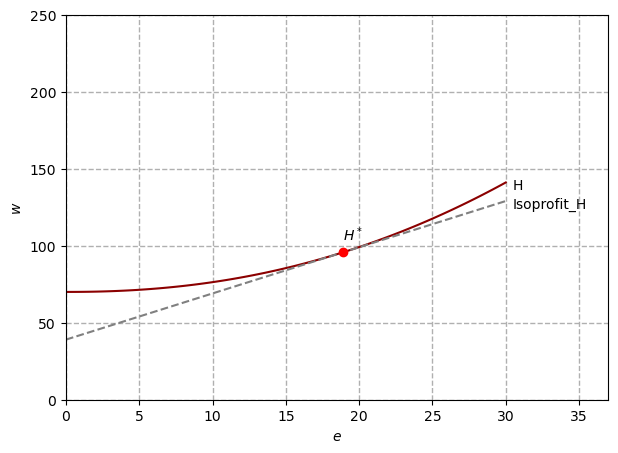

In [86]:
# Implementing only high productivity workers (q=1)

model.par.q=1

model.solve()
print(f'(w_L,e_L,w_H,e_H)=({model.sol.w_L:.3f},{model.sol.e_L:.3f},{model.sol.w_H:.3f}, {model.sol.e_H:.3f})')
print(f'profits={model.profits(model.sol.w_L,model.sol.e_L,model.sol.w_H,model.sol.e_H):.3f}')
model.find_indifference_curves()
model.find_isoprofit_curves()
model.plot_everything()

Now, this is an interesting result. We find that both the number of years of education demanded and the wage paid fall in equilibrium for the high-productive workers. The reason is that there exists no low-productive workers in this economy. Therefore, the principal will no longer have to demand a relatively higher education level (and pay relatively higher wages) in order to secure that only high-productive workers accept the high-productive contract. 

In other words, **the $IC_L$ constraint does not bind anymore**, so the principal can demand a lower education level and pay lower wages because it does no longer have keep the low productive away from the contracts designed for the high productive (there is no information cost). With only one type of agent in the economy (high productive), this is exactly what we would expect.



### Part 5: What if we added more types of workers to the model?

$$
\begin{align*}
\max_{w_1,w_2,\ldots,w_n,e_1,e_2,\ldots,e_n} \pi  & = q_{1}(R_1 - w_1)+q_{2}(R_2 - w_2)+ \cdots +q_{n}(R_n - w_n)\\
& \text{s.t.} \\
\tag{$IR_i$}u_i(w_i,e_i) & \ge r_i  \\ 
\tag{$IC_i$}u_i(w_i,e_i) & \ge u_i(w_j,e_j)\\
\end{align*}
$$

for all $i,j\in \{1,\ldots,n\}$ and $i \neq j$. Moreover, $q_i$ denotes the share of total workers characterized as worker type $i$ 

In [87]:
model = PrincipalAgent()
model.setup_many()

In [88]:
model.solve_many()

for i in range(model.ext.n):
    if i>=9:
        print(f'Worker type {i+1}:  (y,w,e) = ({model.ext.y_vec[i]:.2f}, {model.sol.w_vec[i]:.2f}, {model.sol.e_vec[i]:.2f})')
    else:
        print(f'Worker type {i+1}:   (y,w,e) = ({model.ext.y_vec[i]:.2f}, {model.sol.w_vec[i]:.2f}, {model.sol.e_vec[i]:.2f})')


print(f'\nprofits = {model.profits_many(*model.sol.w_vec, *model.sol.e_vec):.2f}')



Worker type 1:   (y,w,e) = (28.82, 69.41, 1.48)
Worker type 2:   (y,w,e) = (107.68, 81.39, 7.72)
Worker type 3:   (y,w,e) = (113.33, 81.67, 7.81)
Worker type 4:   (y,w,e) = (148.61, 82.96, 8.23)
Worker type 5:   (y,w,e) = (163.12, 95.24, 11.24)
Worker type 6:   (y,w,e) = (188.98, 142.09, 18.68)
Worker type 7:   (y,w,e) = (222.10, 144.59, 19.07)
Worker type 8:   (y,w,e) = (243.32, 144.83, 19.11)
Worker type 9:   (y,w,e) = (274.10, 190.94, 27.99)
Worker type 10:  (y,w,e) = (278.10, 190.96, 28.00)

profits = 111.14


In [89]:
model.solve_many1()

for i in range(model.ext.n):
    if i>=9:
        print(f'Worker type {i+1}:  (y,w,e) = ({model.ext.y_vec[i]:.2f}, {model.sol.w_vec[i]:.2f}, {model.sol.e_vec[i]:.2f})')
    else:
        print(f'Worker type {i+1}:   (y,w,e) = ({model.ext.y_vec[i]:.2f}, {model.sol.w_vec[i]:.2f}, {model.sol.e_vec[i]:.2f})')


print(f'\nprofits = {model.profits_many(*model.sol.w_vec, *model.sol.e_vec):.2f}')


Worker type 1:   (y,w,e) = (28.82, 0.00, 0.00)
Worker type 2:   (y,w,e) = (107.68, 81.39, 7.72)
Worker type 3:   (y,w,e) = (113.33, 81.67, 7.81)
Worker type 4:   (y,w,e) = (148.61, 82.96, 8.23)
Worker type 5:   (y,w,e) = (163.12, 95.24, 11.24)
Worker type 6:   (y,w,e) = (188.98, 142.09, 18.68)
Worker type 7:   (y,w,e) = (222.10, 144.59, 19.07)
Worker type 8:   (y,w,e) = (243.32, 144.83, 19.11)
Worker type 9:   (y,w,e) = (274.10, 190.94, 27.99)
Worker type 10:  (y,w,e) = (278.10, 190.96, 28.00)

profits = 112.15


Mangler:
1. Skriv antagelser op. Vi har antaget, at:
    * produktivitetsniveau og disnytte ved uddannelse er begge trukket fra en uniform fordeling de hhv. i intervaller [50.0; 300.0) og [1.0; 3.0)
    * disnytte ved uddannelse og produktivitetsniveau er negativt korreleret
    * At outside option er en positiv deterministisk funktion af produktivitetsniveau, og at outside option altid er mindre end produktivitetsniveauet. Helt specifikt $r=0.3y$
    * Andelen af de forskellige typer arbejdere er også trukket fra en uniform fordeling, og vi antager at principal kender fordelingen.
    * Vi antager for simpliciteten, at der kun er indre løsninger. Dvs., at det vil være optimalt at tilbyde alle arbejdertyper en kontrakt. 

2. Vis baseline parametre for udvidet model

3. Lav 3D-plot med, hvor x=education, y=wage og z=productivity level

4. Lav interaktiv figur i forrige del, hvor q varierer.

5. Skriv pseudo algoritme for alle dele og kommenter på kode i py-file

6. Evt. udvid model, så den sammenligner profit med tilfælde, hvor principal vælger ikke at tilbyde kontrakt til bestemte typer arbejdere.

# Conclusion

In this assignment we have solved the Principal-Agent model numerically.

#### **Part 1**
In the first part we do not allow the principal to condition on the agents' years of education (no screening available). Therefore, the principal can only supply one contract to both types of workers. We find that this solution depends strongly on the parameters chosen, especially the reservation utility (outside option). We find that this version of the model can result in the three different solutions:

**1.** The principal hires the both types of workers and incur *positive* profits and pays a relatively *high* wage

**2.** The principal hires the low productivity workers and incur *positive* profits and pays a relatively *low* wage

**3.** The principal chooses *not to hire* the two agents and incurs zero profits

#### **Part 2**
We expand the model. Now, we allow for the principal to condition on the agents' years of education (screening available) and thus for the principal to offer the two agents different contracts, where the required number of years of education and the wage varies. 

We find that this version of the model implies that the high-productive workers are demanded to have a significantly longer education and in exchange receive a significantly higher wage than low-productive workers. We know that this equilibrium implies that the $IR_L$ and $IC_L$ constraints bind.



#### **Part 3**

Lastly, we analyze the implications of different values of q in the model. That is, we analyze the implication of changing the share of high-productive workers in the economy. 

We find that for $q=0$ (only low-productive workers), the contract offered to the low-productive is unchanged from the equilibrium in part 2. This is beacuase the $IR_L$ constraint still binds.

However, for $q=1$ we find that the high-productive workers are demanded to have a shorter education and thus receive a lower wage, when there only exists the productive type of agents in the economy. This is because the $IC_L$ does not bind anymore.